### Large dataset
> - 500,000 Notes extracted across 330 songs [9.5GB compressed]
> - Songs with less notes (more often solos) have a larger proportion of their notes selected
> - See "procure_rate" for selection schedule

In [50]:
import os
curr_dir = os.getcwd()
base_dir = os.path.dirname(curr_dir)
# Base directory: /project-noteGen
# Current directory: /core  

import torch
import numpy as np
import csv
import pandas as pd
from scipy.io.wavfile import read as read_wav
import matplotlib.pyplot as plt
import copy

import preprocess
import visualize
import instruments

In [5]:
test_songs = os.listdir(f"{base_dir}/data/raw/test_data/")
train_songs = os.listdir(f"{base_dir}/data/raw/train_data/")

test_ids = [test_song.replace(".wav", "") for test_song in test_songs]
train_ids = [train_song.replace(".wav", "") for train_song in train_songs]

In [3]:
note_counts = []

for test_id in test_ids:
    count = pd.read_csv(f"{base_dir}/data/raw/test_labels/{test_id}.csv").to_numpy().shape[0]
    note_counts.append(count)
for train_id in train_ids:
    count = pd.read_csv(f"{base_dir}/data/raw/train_labels/{train_id}.csv").to_numpy().shape[0]
    note_counts.append(count)

print(f"Median notes per song: {np.median(note_counts):5.0f}")
print(f"Total notes: {np.sum(note_counts):18d}")

Median notes per song:  2821
Total notes:            1089540


In [4]:
def procure_rate(count):
    if count < 1000:
        rate = 1
    elif count < 2000:
        rate = 0.9
    elif count < 4000:
        rate = 0.7
    elif count < 6000:
        rate = 0.4
    elif count < 8000:
        rate = 0.2
    elif count < 10000:
        rate = 0.1
    else:
        rate = 0.05
        
    return int(count * rate)

In [5]:
np.random.seed(0)

note_extractions = [procure_rate(note_count) for note_count in note_counts]
total_notes = np.sum(note_extractions) # 521414

remove_from = np.random.choice(np.arange(330), total_notes - 500000)

for i in remove_from:
    note_extractions[i] -= 1

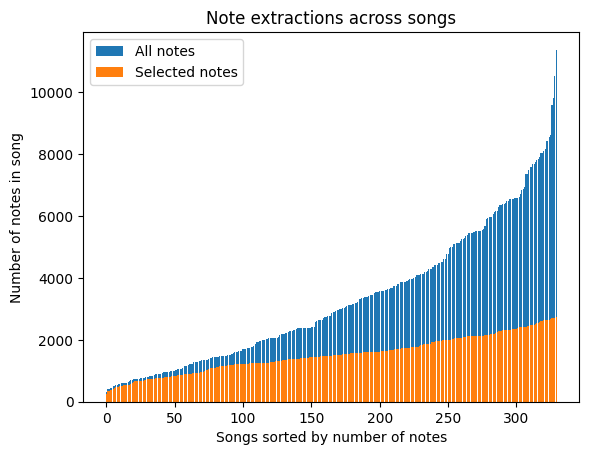

In [6]:
_ = plt.bar(np.arange(330), np.sort(note_counts), label="All notes")
_ = plt.bar(np.arange(330), np.sort(note_extractions), label="Selected notes")
plt.xlabel("Songs sorted by number of notes")
plt.ylabel("Number of notes in song")
plt.title("Note extractions across songs")
_ = plt.legend()

In [7]:
np.random.seed(0)

song_idx = 0
selections = [None]*330

for test_id in test_ids:
    
    notes_in_song = note_counts[song_idx]
    notes_to_take = note_extractions[song_idx]
    selections[song_idx] = np.random.choice(np.arange(notes_in_song), notes_to_take, replace=False)
    song_idx += 1

for train_id in train_ids:
    
    notes_in_song = note_counts[song_idx]
    notes_to_take = note_extractions[song_idx]
    selections[song_idx] = np.random.choice(np.arange(notes_in_song), notes_to_take, replace=False)
    song_idx += 1

In [8]:
# Collect all raw labels and songs (1 minute)

all_labels = [None]*330
all_songs = [None]*330

song_idx = 0

for test_id in test_ids:
    
    all_labels[song_idx] = pd.read_csv(f"{base_dir}/data/raw/test_labels/{test_id}.csv").to_numpy()
    
    preprocess.downsample_wav(f"{base_dir}/data/raw/test_data/{test_id}.wav", f"{base_dir}/data/large/temp.wav", rate=22050)
    all_songs[song_idx] = read_wav(f"{base_dir}/data/large/temp.wav")[1]
    
    song_idx += 1
    
for train_id in train_ids:
    
    all_labels[song_idx] = pd.read_csv(f"{base_dir}/data/raw/train_labels/{train_id}.csv").to_numpy()
    
    preprocess.downsample_wav(f"{base_dir}/data/raw/train_data/{train_id}.wav", f"{base_dir}/data/large/temp.wav", rate=22050)
    all_songs[song_idx] = read_wav(f"{base_dir}/data/large/temp.wav")[1]
    
    song_idx += 1
    
os.remove(f"{base_dir}/data/large/temp.wav")
print("complete")

complete


In [9]:
# Construct large dataset labels (30s)
np.random.seed(0)

labels_centered = [None]*500000

all_ids = test_ids + train_ids
note_idx = 0

for song_idx, song_id in enumerate(all_ids):

    song_label = all_labels[song_idx]
    note_selections = selections[song_idx]

    for note_selection in note_selections:

        label = song_label[note_selection]
        
        note_length = label[1] - label[0]
        window_start = label[0]
        window_end = label[1]

        if note_length < 16000:
            extension = 16000 - note_length
            sub_extension = np.array_split(np.arange(extension), 2)
            window_start = label[0] - sub_extension[1].size
            window_end = label[1] + sub_extension[0].size
        elif note_length > 16000:
            trimming = note_length - 16000
            sub_trimming = np.array_split(np.arange(trimming), 2)
            window_start = label[0] + sub_trimming[1].size
            window_end = label[1] - sub_trimming[0].size

        assert window_end - window_start == 16000
        # assert window_start >= 0
        
        centered_label = [song_id, note_selection] + list(label)
        centered_label[2] = window_start
        centered_label[3] = window_end
        labels_centered[note_idx] = centered_label
        note_idx += 1

columns = ['source_song_id', 'note_from_song', 'start_time', 'end_time', \
           'instrument', 'key', 'start_beat', 'end_beat', 'note_value']

#labels_centered_df = pd.DataFrame(labels_centered, columns=columns)
#labels_centered_df.to_csv(f"{base_dir}/data/large/labels_centered.csv", index=False)
print("done")

done


In [ ]:
# Construct large dataset samples (9.5 GB, 10 min)

time_factor = 22050 / 44100

notes_padded = [None]*500000

note_idx = 0

for song_idx, song_id in enumerate(all_ids):
    
    song_label = all_labels[song_idx]
    song_raw = all_songs[song_idx]
    note_selections = selections[song_idx]
    
    #print(f"Working on song {song_idx}")
    
    for note_selection in note_selections:
        
        label_original = song_label[note_selection]
        label_centered = labels_centered[note_idx]
        
        original_start = int(label_original[0] * time_factor)
        original_end = int(label_original[1] * time_factor)
        original_length = original_end - original_start
        
        window_start = int(label_centered[2] * time_factor)
        window_end = int(label_centered[3] * time_factor)
        window_length = window_end - window_start
        
        if original_length > window_length:
            note_padded = song_raw[window_start:window_end].copy()
        
        elif original_length < window_length:
            
            note_original = song_raw[original_start:original_end].copy()
            
            small_half = int(original_length / 2)
            inner_start = 3999 - small_half
            inner_end = 3999 + (original_length - small_half)

            note_padded = np.zeros(8000)
            note_padded[inner_start:inner_end] = note_original
            assert np.array_equal(note_original, note_padded[inner_start:inner_end])
            
        else:
            raise Exception(f"Song: {song_id}\n" \
                            f"Original span: {original_start} to {original_end}\n" \
                            f"Centered span: {window_start} to {window_end}\n")
            
        notes_padded[note_idx] = note_padded
        note_idx += 1

notes_padded_dict = {}

for subset_i in range(50):
    notes_padded_dict.update({str(subset_i): \
        np.array(notes_padded[subset_i*10000:(subset_i+1)*10000], dtype = np.float32)})
    #print(f"Including {subset_i*10000} to {(subset_i+1)*10000}")

#np.savez_compressed(f"{base_dir}/data/large/notes_padded.npz", **notes_padded_dict)
print("done")

#### Visualize Large Dataset

In [65]:
size = preprocess.get_folder_size(f"{base_dir}/data/large/")
print(f"Large dataset: {size:.2f} GB")

subset = 24
X_file = np.load(f"{base_dir}/data/large/notes_padded.npz", mmap_mode='r')
X_subset = X_file[str(subset)]
Y = pd.read_csv(f"{base_dir}/data/large/labels_centered.csv").to_numpy()
Y_subset = Y[subset*10000:(subset+1)*10000]

Large dataset: 9.52 GB


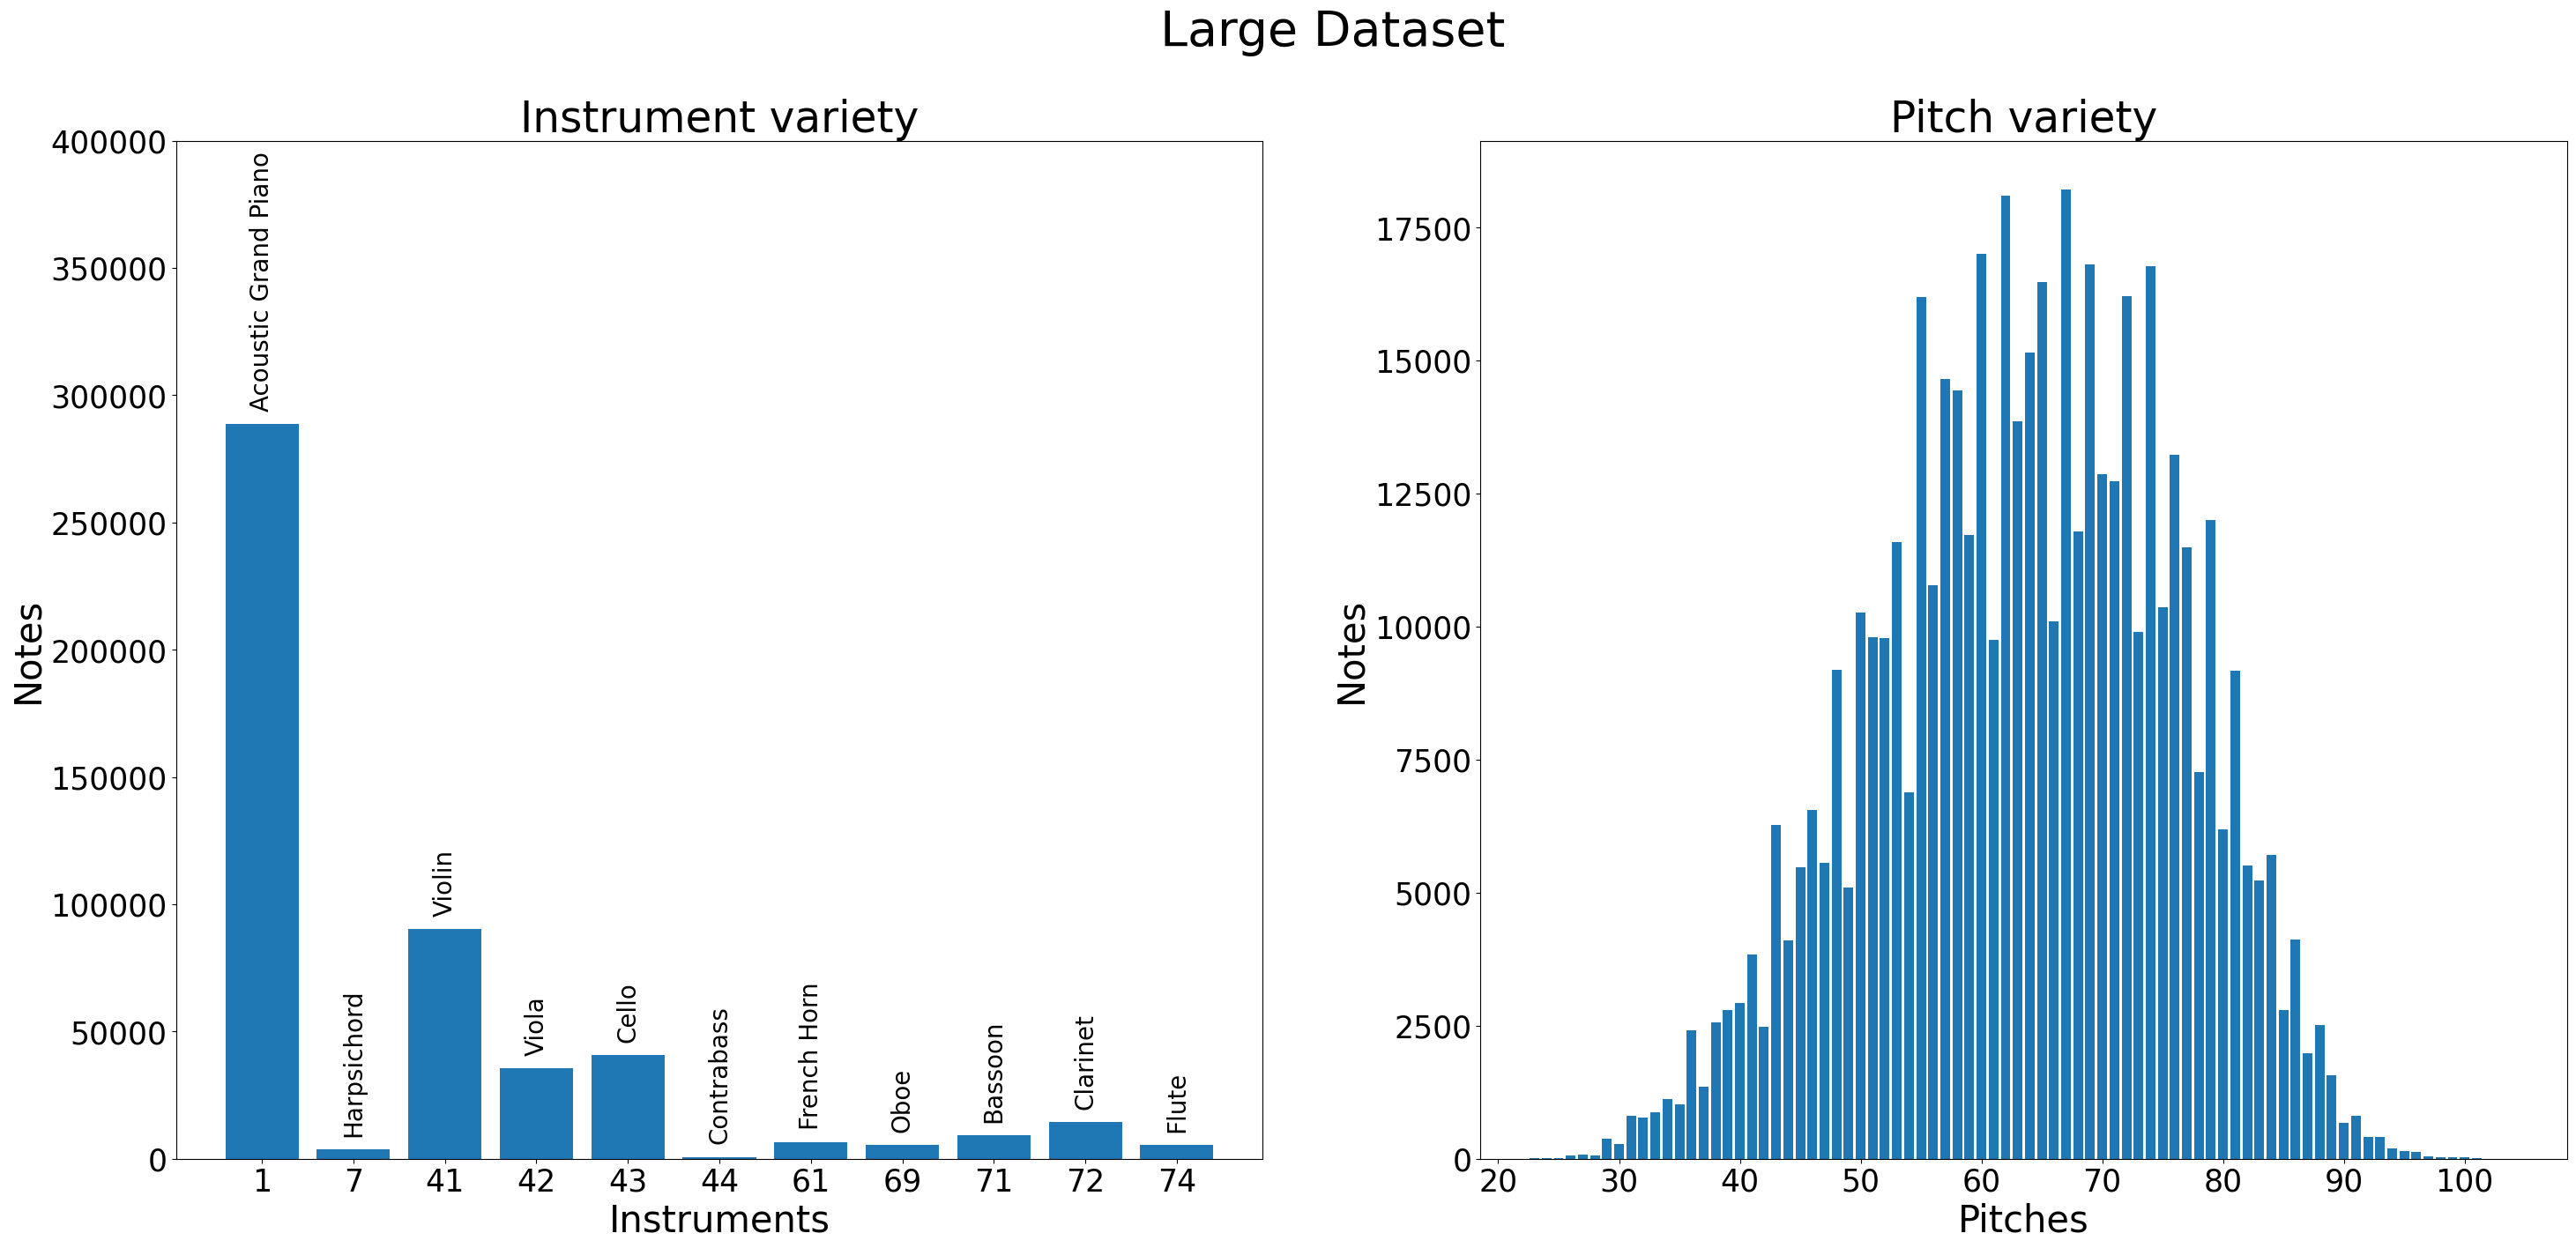


Acoustic Grand Piano:        288,637 notes
Harpsichord:                   3,570 notes
Violin:                       90,226 notes
Viola:                        35,466 notes
Cello:                        40,824 notes
Contrabass:                      719 notes
French Horn:                   6,497 notes
Oboe:                          5,296 notes
Bassoon:                       9,146 notes
Clarinet:                     14,290 notes
Flute:                         5,329 notes


In [182]:
instrument_variety, instrument_counts = np.unique(Y[:, 4], return_counts=True)    #1-74
pitch_variety, pitch_counts = np.unique(Y[:, 5], return_counts=True)    #23-104

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[35, 15])
fig.suptitle("Large Dataset", fontsize=40)

ax1.bar([str(i) for i in instrument_variety], instrument_counts)
ax1.set(xlabel='Instruments', ylabel='Notes', title='Instrument variety')
ax1.tick_params(labelsize=25)
ax1.xaxis.label.set_size(30)
ax1.yaxis.label.set_size(30)
ax1.title.set_size(35)
ax1.set_ylim([0, 400000])

bars = ax1.patches
labels = [instruments.get[i] for i in instruments_variety]

for bar, label in zip(bars, labels):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+5000, label,
             fontsize=20, ha='center', va='bottom', rotation=90)
        
ax2.bar(pitch_variety, pitch_counts)
ax2.set(xlabel='Pitches', ylabel='Notes', title='Pitch variety')
ax2.tick_params(labelsize=25)
ax2.xaxis.label.set_size(30)
ax2.yaxis.label.set_size(30)
ax2.title.set_size(35)

plt.subplots_adjust(wspace=0.2)
plt.show()

instrument_info = []
for instrument, count in zip(instrument_variety, instrument_counts):
    instrument_title = f"{instruments.get[instrument]}:"
    instrument_info.append(f"{instrument_title} {count:>{35-len(instrument_title)},} notes")

instrument_info = "\n".join(instrument_info)

print("\n" + instrument_info)

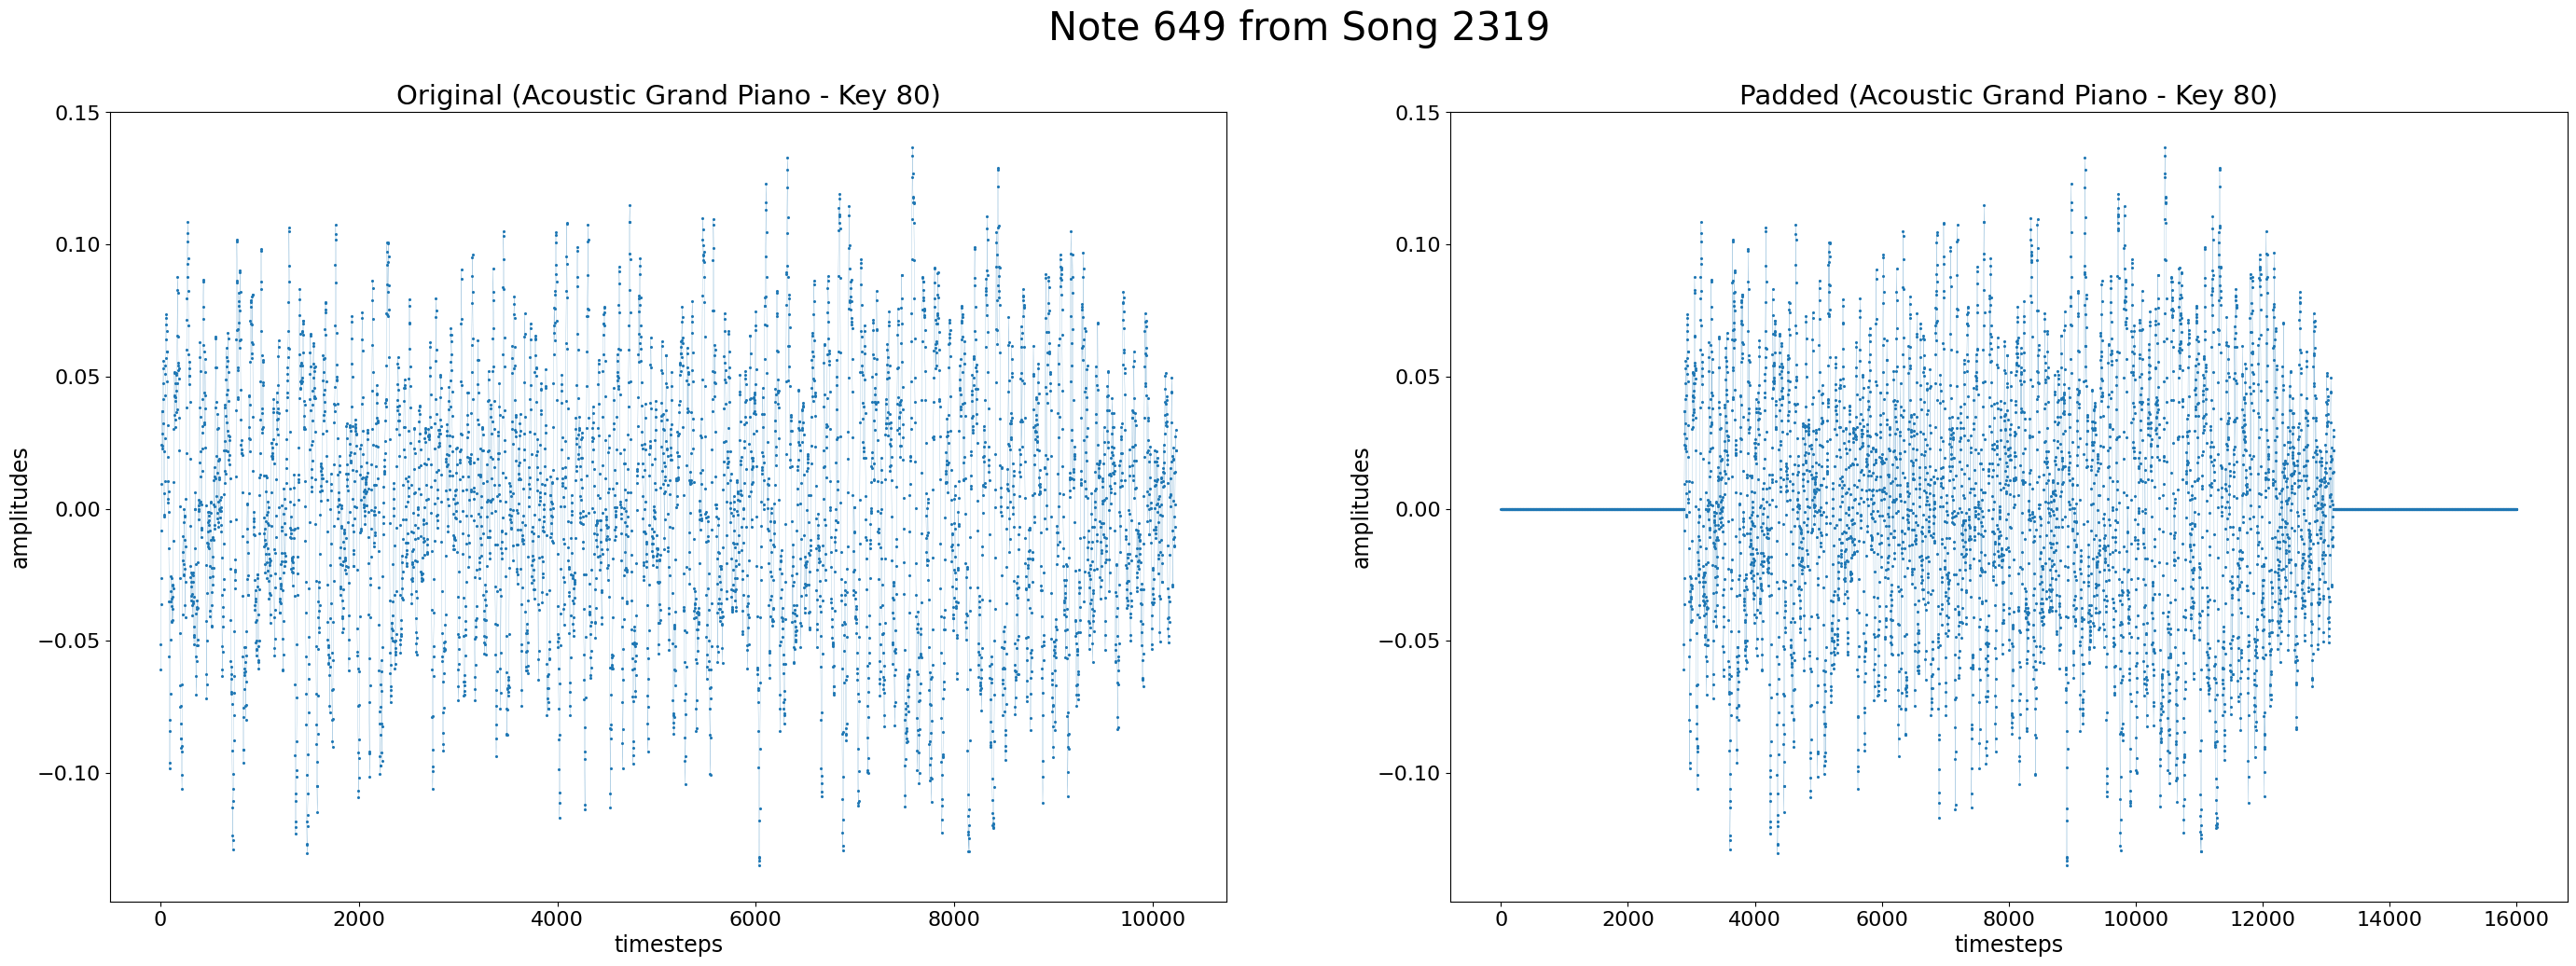

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

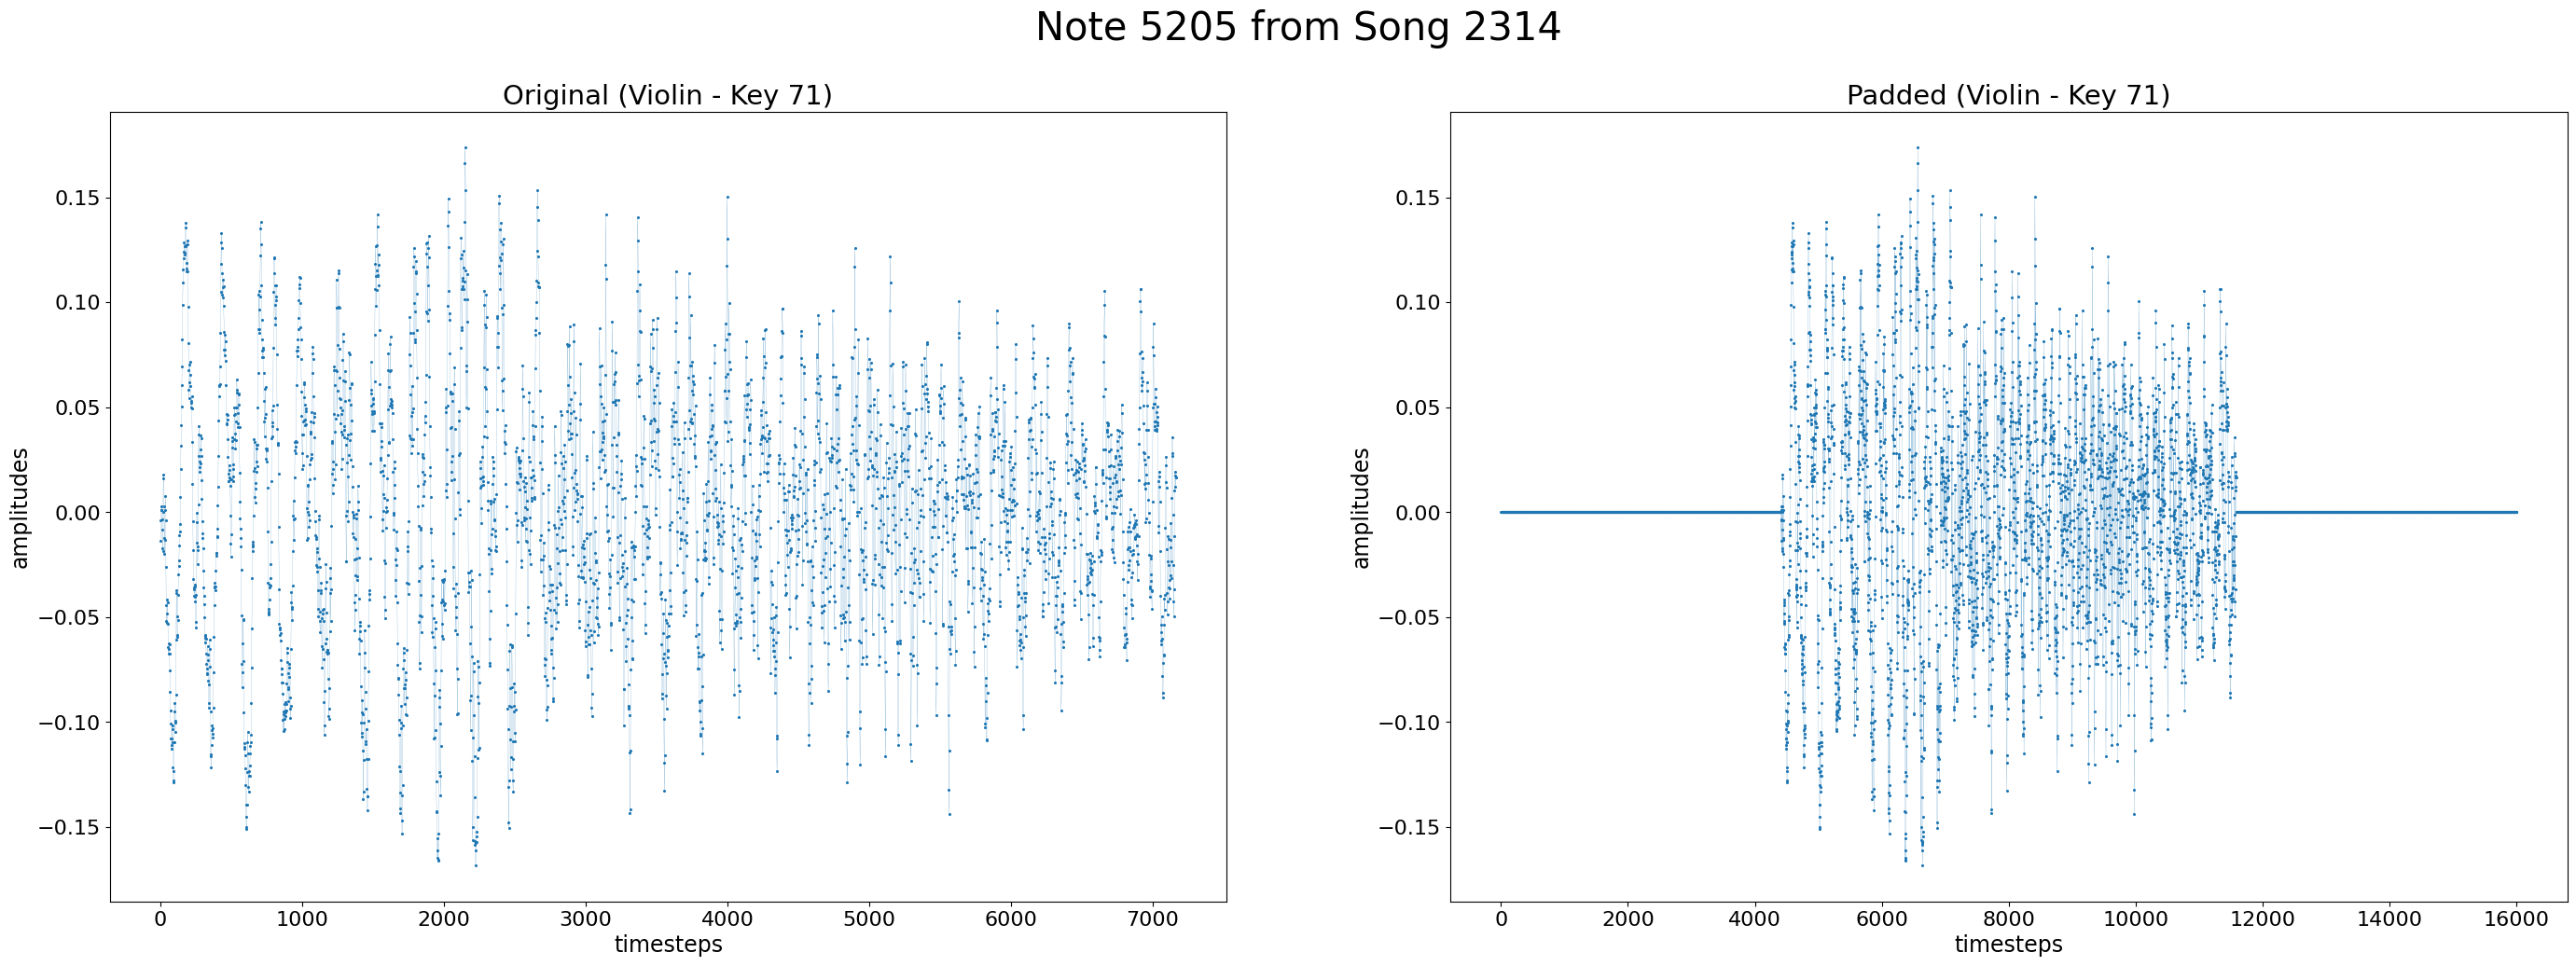

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

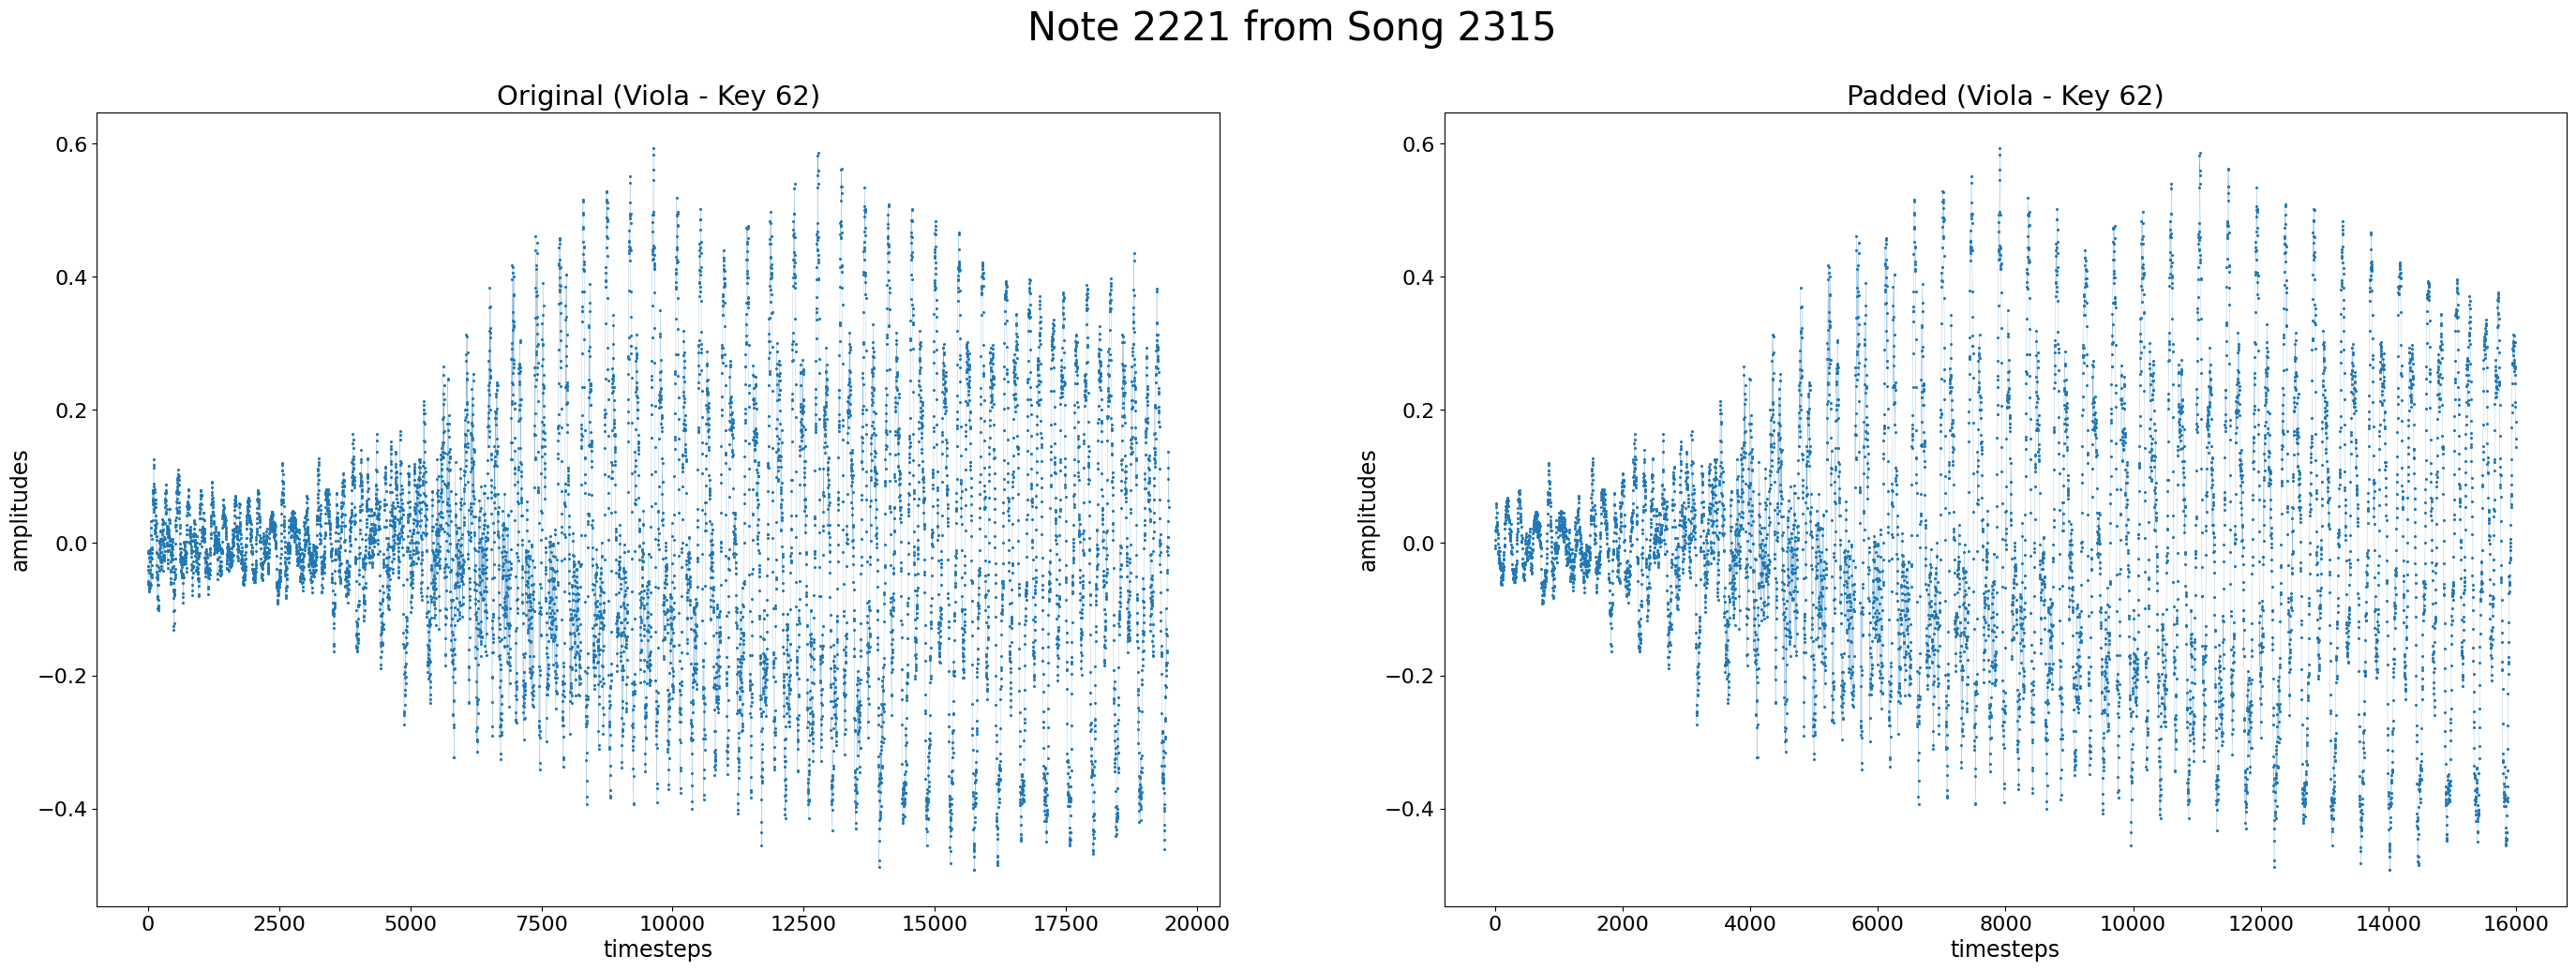

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [171]:
np.random.seed(5)
indices = np.random.choice(np.arange(10000), 3, replace=False)

for index in indices:
    
    note_padded = X_subset[index]
    label_padded = Y_subset[index]

    song_id = label_padded[0]
    note_id = label_padded[1]
    location = 'test' if song_id in test_ids else 'train'

    labels = pd.read_csv(f"{base_dir}/data/raw/{location}_labels/{song_id}.csv").to_numpy()

    preprocess.downsample_wav(f"{base_dir}/data/raw/{location}_data/{song_id}.wav", \
                              f"{base_dir}/data/large/temp.wav", rate=22050)
    song = read_wav(f"{base_dir}/data/large/temp.wav")
    os.remove(f"{base_dir}/data/large/temp.wav")

    note_samples = preprocess.construct_note_samples(song, labels, ds_rate=22050)

    note_original = note_samples[note_id]
    label_original = labels[note_id]

    visualize.vis_notes_as_original([note_original, note_padded], [label_original, label_padded], \
                                    [2, 2], title=f"Note {note_id} from Song {song_id}", \
                                    titles=["Original", "Padded"])
    visualize.play_notes([note_original, note_padded])